In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import seaborn as sns
import json
import torch
import pickle

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DeJavu Serif"


In [2]:
df_all = pd.DataFrame()

In [3]:
# 08092024: synthetic data v3 
# 08052024: synthetic data v1 
# 08022024: baselines skillit
# perp_folders = ["../output/08092024/", "../output/08052024/", "../output/08032024/"]
# perp_folders = ["../output/synthetic_compare/"]
# perp_folders = ["../output/test_real_095_split"]
# perp_folders = ["../output/synthetic_fractions2/real_095_split"]
# perp_folders = ["../output/08212024/"]
# perp_folders = ["../output/augment/"]
perp_folders = ["../output/08272024/"]

In [4]:

for perp_folder in perp_folders:
    files = os.listdir(perp_folder)
    files = [os.path.join(perp_folder, f) for f in files] # add path to each file
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)

    # print(files)
    
    for file in files:        
        if "opposite" in file or "emb" in file or "predictions" in file or "proportions" in file:
            continue 
        
        # if "english" not in file:
        #     continue 
                
        if ".log" in file:
            continue
        print(file)
        method = file.split("/")[-1]
        
        runs = os.listdir(file)
        
        for run in runs:
            if "proportions" in run:
                continue 
            seed = int(run.split("seed_")[-1].split("_")[0])
            checkpoint = int(run.split("-")[-1].split(".")[0])
            if len(df_all) != 0:
                if len(df_all.loc[(df_all.method==method) & (df_all.seed == seed) & (df_all.index==checkpoint)]) != 0:
                    continue 
                
            path = os.path.join(file, run)
            print(path)
                
            loss_dict = pd.read_pickle(path)
        
        
            df = pd.DataFrame([{"skill": k, "loss": [values.numpy() if torch.is_tensor(values) else values for values in v]} for k, v in loss_dict.items()])
            df["perplexity"] = pd.Series([np.exp(l) for l in df["loss"].values])
            df["average_loss"] = pd.Series([sum(l)/len(l) for l in df["loss"].values])
            df["average_perplexity"] = pd.Series([sum(p)/len(p) for p in df["perplexity"].values])
            df["method"] = method
            df["seed"] = seed
            df["checkpoint"] = checkpoint


            df.set_index("checkpoint", inplace=True)


            df_all = pd.concat([df_all, df])
    


../output/08272024/ni_xlingual_600_mixture_question_answering_spanish_spanish_question_genera_targetmask_01_mean_spanish_qa_qg_only_greedy_100_eta_0.8_lookback_3_checkpoints
../output/08272024/ni_xlingual_600_mixture_question_answering_spanish_spanish_question_genera_targetmask_01_mean_spanish_qa_qg_only_greedy_100_eta_0.8_lookback_3_checkpoints/seed_3_checkpoint-0.pkl
../output/08272024/ni_xlingual_600_mixture_question_answering_spanish_spanish_question_genera_targetmask_01_mean_spanish_qa_qg_only_greedy_100_eta_0.8_lookback_3_checkpoints/seed_1_checkpoint-0.pkl
../output/08272024/ni_xlingual_600_mixture_question_answering_spanish_spanish_question_genera_targetmask_01_mean_spanish_qa_qg_only_greedy_100_eta_0.8_lookback_3_checkpoints/seed_2_checkpoint-100.pkl
../output/08272024/ni_xlingual_600_mixture_question_answering_spanish_spanish_question_genera_targetmask_01_mean_spanish_qa_qg_only_greedy_100_eta_0.8_lookback_3_checkpoints/seed_0_checkpoint-500.pkl
../output/08272024/ni_xlingual

In [5]:
def aggregate_skill(x, ppl=True):
    if ppl:
        total_ppl = x["perplexity"].apply(lambda x: sum(x)).sum()
        count_ppl = x["perplexity"].apply(lambda x: len(x)).sum()
        metric_name = "skill_perplexity"
        metric = total_ppl/count_ppl
    else:
        total_loss = x["loss"].apply(lambda x: sum(x)).sum()
        count_loss = x["loss"].apply(lambda x: len(x)).sum()
        metric_name = "skill_loss"
        metric = total_loss/count_loss

    names = {metric_name: metric}
    
    return pd.Series(names, index=[metric_name])



In [6]:
sorted(df_all.method.unique())

['ni_xlingual_100_mixture_question_answering_english_english_question_answer_weights_0000_static',
 'ni_xlingual_100_mixture_question_answering_english_english_question_answer_weights_0000_targetmask_0001_mean_spanish_qg_normalized_greedy_100_eta_0.8_lookback_3_checkpoints',
 'ni_xlingual_100_mixture_question_answering_spanish_spanish_question_genera_targetmask_01_mean_spanish_qa_qg_only_greedy_100_eta_0.8_lookback_3_checkpoints',
 'ni_xlingual_100_mixture_question_answering_spanish_spanish_question_genera_weights_00_static',
 'ni_xlingual_600_mixture_question_answering_spanish_spanish_question_genera_targetmask_01_mean_spanish_qa_qg_only_greedy_100_eta_0.8_lookback_3_checkpoints']

[3 1 2 0 4]
checkpoint
600    2.257823
600    2.311735
Name: skill_loss, dtype: float64


/tmp/ipykernel_2057936/1422280854.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()


Text(0.5, 1.0, 'Targeted learning of Spanish question generation - Spanish QA')

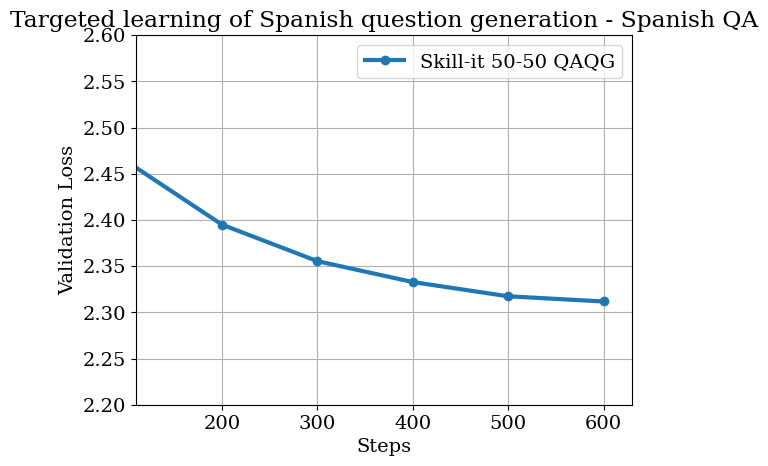

In [7]:


methods = [
    # "ni_xlingual_600_mixture_question_answering_english_english_question_answer_weights_0001_static",
#    "ni_xlingual_600_stratified_question_answering_english_english_question_answer_static",
#    "real_00_split",
#    "ni_xlingual_600_mixture_question_answering_english_english_question_answer_weights_0000_static",
    # "ni_xlingual_600_mixture_question_answering_english_english_question_answer_targetmask_0001_mean_spanish_qg_normalized_greedy_100_eta_0.8_lookback_3_checkpoints",
#    "target_only",
   'ni_xlingual_600_mixture_question_answering_spanish_spanish_question_genera_targetmask_01_mean_spanish_qa_qg_only_greedy_100_eta_0.8_lookback_3_checkpoints',
]

# labels = ["Skill-it", "50-50 spanish QA QG", "Target Only"]
# labels = ["Skill-it", "Real + Synthetic Augmentation", "Target Only"]
labels = ["Skill-it 50-50 QAQG"]

# methods = [
#     "real",
    # "synthetic_v2",
    # "synthetic_v3",
    # "synthetic_v4",
    # "synthetic_v4_05_split",
    # "synthetic_v4_075_split",
    # "synthetic_v4_09_split",
    # "target_only",

    # "ni_xlingual_600_mixture_question_answering_english_english_question_answer_targetmask_0001_mean_spanish_qg_normalized_greedy_100_eta_0.8_lookback_3_checkpoints copy",
    # "english_v3",
    # "ni_xlingual_600_mixture_question_answering_english_english_question_answer_targetmask_0001_mean_spanish_qg_normalized_greedy_100_eta_0.8_lookback_3_checkpoints",
    # "ni_xlingual_600_mixture_question_answering_english_english_question_answer_targetmask_0001_mean_spanish_qg_normalized_greedy_100_eta_0.8_lookback_3_checkpoints",
# ]
# labels = [
#     "Skill-It", 
#     # "Synthetic v1", 
#     # "Synthetic v2", 
#     "Synthetic v4", 
#     "Synthetic v4 (0.5 split)",
#     "Synthetic v4 (0.75 split)",
#     "Synthetic v4 (0.9 split)",
#     "Target Baseline"
# ]

assert len(methods) == len(labels)
plt.figure()
seeds=[0, 1, 2, 3, 4]


for i, method in enumerate(methods):
    
    df_shuffled = df_all.loc[df_all.method == method].sort_index()
    print(df_shuffled.seed.unique())
    df_shuffled = df_shuffled.loc[df_shuffled.seed.isin(seeds)]
    df_overall = df_shuffled.groupby([df_shuffled.index]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
    df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
    df_shuffled.set_index("checkpoint", inplace=True)
    df_overall.set_index("checkpoint", inplace=True)
    df_overall.drop([0], inplace=True)

    df_shuffled.loc[df_shuffled.skill == "question_generation_spanish_spanish"].skill_loss.plot(marker="o", label=labels[i], lw=3)
    print(df_shuffled.loc[df_shuffled.index == df_shuffled.index.max()].skill_loss)



plt.xlim(110, )
plt.ylim(2.2, 2.6)
plt.xlabel("Steps")
plt.ylabel("Validation Loss")
plt.legend(loc='upper right')
plt.grid()
plt.title("Targeted learning of Spanish question generation - Spanish QA")


In [17]:
df_all.columns

Index(['skill', 'loss', 'perplexity', 'average_loss', 'average_perplexity',
       'method', 'seed'],
      dtype='object')

In [26]:
df_all[df_all['skill'] == "question_generation_spanish_spanish"].sort_values(by=["checkpoint", "seed"])

,skill,loss,perplexity,average_loss,average_perplexity,method,seed
checkpoint,,,,,,,
0,question_generation_spanish_spanish,"[2.8477883, 3.0934598, 2.7725923, 2.9614944, 2...","[17.24959, 22.053247, 16.000057, 19.326834, 9....",2.920899,19.263206,ni_xlingual_600_mixture_question_answering_eng...,0
0,question_generation_spanish_spanish,"[2.8799655, 3.145936, 2.5499837, 2.8836033, 2....","[17.81366, 23.241417, 12.806894, 17.87858, 16....",2.912400,19.151660,ni_xlingual_600_mixture_question_answering_eng...,1
0,question_generation_spanish_spanish,"[2.8111508, 2.3343627, 3.187772, 2.8529174, 2....","[16.629044, 10.32288, 24.234375, 17.338291, 16...",2.918779,19.343482,ni_xlingual_600_mixture_question_answering_eng...,2
0,question_generation_spanish_spanish,"[2.749771, 3.4148657, 2.72377, 3.0468252, 2.92...","[15.639052, 30.412868, 15.237659, 21.048412, 1...",2.916496,19.250611,ni_xlingual_600_mixture_question_answering_eng...,3
0,question_generation_spanish_spanish,"[2.35559, 2.4685526, 2.6569357, 2.8469462, 2.7...","[10.54435, 11.805346, 14.252547, 17.23507, 15....",2.910948,19.231240,ni_xlingual_600_mixture_question_answering_eng...,4
100,question_generation_spanish_spanish,"[2.3960927, 2.7060003, 2.3566809, 2.5443578, 2...","[10.980189, 14.969283, 10.555857, 12.735046, 8...",2.546488,13.318638,ni_xlingual_600_mixture_question_answering_eng...,0
100,question_generation_spanish_spanish,"[2.4664552, 2.7137816, 2.5337408, 2.4359646, 2...","[11.780613, 15.086217, 12.600554, 11.426835, 1...",2.567993,13.647678,ni_xlingual_600_mixture_question_answering_eng...,1
100,question_generation_spanish_spanish,"[2.418834, 2.1956108, 2.6235673, 2.4529681, 2....","[11.232754, 8.985488, 13.784812, 11.622793, 10...",2.564485,13.591952,ni_xlingual_600_mixture_question_answering_eng...,2
100,question_generation_spanish_spanish,"[2.3483958, 3.049608, 2.2331553, 2.916909, 2.7...","[10.468762, 21.107069, 9.329256, 18.484064, 16...",2.592310,13.955413,ni_xlingual_600_mixture_question_answering_eng...,3


In [43]:
# df_all[df_all['skill'] == "question_generation_spanish_spanish"].sort_values(by=["checkpoint", "seed"])
df_all[df_all.index == 600].sort_values(by=["checkpoint", "seed"]).groupby("skill").agg({"average_loss": "mean"})

,average_loss
skill,
question_answering_english_english,2.718926
question_answering_spanish_spanish,1.583033
question_generation_english_english,2.878385
question_generation_spanish_spanish,2.442097
